In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark
!pip install pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=09a85eaef61f50ecb12ca791170fb06aeed706537465be5653196f9bbdbe8826
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.0/670.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 30.3 MB/s eta 0:00:00


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


+----------+-----+
|  category|count|
+----------+-----+
|     mazda| 2058|
|mitsubishi|  615|
|    nissan| 3256|
|   hyundai| 3839|
|      ford| 2858|
|      audi| 2156|
|  mercedes| 1707|
|     honda| 1318|
|    toyota| 5667|
|       bmw| 2104|
+----------+-----+



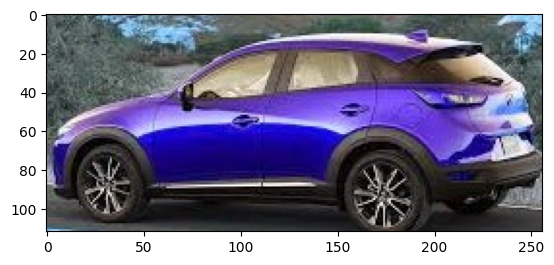

In [3]:
#Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math
import shutil
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.appName("CarImageDetection").getOrCreate()

# Directory setup
Directory = "/content/drive/MyDrive/Cars_Dataset"
CATEGORIES = os.listdir(Directory)

# Function to count images using PySpark
def count_images_pyspark(directory, categories):
    # Initialize empty DataFrame
    df = spark.createDataFrame([], schema="category STRING, filename STRING")
    # Read data using PySpark
    for category in categories:
        category_path = os.path.join(directory, category)
        file_list = os.listdir(category_path)
        data = [(category, file) for file in file_list]
        category_df = spark.createDataFrame(data, schema="category STRING, filename STRING")
        df = df.union(category_df)
    # Count images per category
    df.groupBy("category").count().show()

# Example usage of PySpark to count images
count_images_pyspark(Directory, CATEGORIES)

# Existing functionality
for category in CATEGORIES:
    Path = os.path.join(Directory, category)
    for img in os.listdir(Path):
        img_array = cv2.imread(os.path.join(Path, img))
        plt.imshow(img_array)
        plt.show()
        break
    break


In [4]:
Directory = "/content/drive/MyDrive/Cars_Dataset"
image_data = []

for category in os.listdir(Directory):
    category_path = os.path.join(Directory, category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        image_data.append((category, img_path))

image_df = spark.createDataFrame(image_data, ["category", "img_path"])
image_data

[('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx3-gen-2015-2020-15.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx3-gen-2015-2020-132.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx5-gen-2012-2020-145.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx3-gen-2015-2020-95.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx5-gen-2012-2020-105.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx5-gen-2012-2020-119.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx3-gen-2015-2020-81.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx3-gen-2015-2020-139.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx3-gen-2015-2020-89.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-6-gen-2014-2020-9.jpg'),
 ('mazda',
  '/content/drive/MyDrive/Cars_Dataset/mazda/mazda-cx3-gen-2015-2020-82.jpg'),
 ('mazda

In [5]:
# Import PySpark libraries


#FEATURE EXTRACTION

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [6]:

def extract_image_features(img_path):
    img_array = img_to_array(load_img(img_path, target_size=(224, 224)))
    return img_array.flatten().tolist()

# Register the UDF
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

extract_features_udf = udf(extract_image_features, ArrayType(FloatType()))

# Assume image_df is a PySpark DataFrame that has an 'img_path' column
# Apply the UDF to extract features
image_df = image_df.withColumn("features", extract_features_udf("img_path"))

# Show the DataFrame
image_df.show()

+--------+--------------------+--------------------+
|category|            img_path|            features|
+--------+--------------------+--------------------+
|   mazda|/content/drive/My...|[98.0, 99.0, 91.0...|
|   mazda|/content/drive/My...|[0.0, 0.0, 0.0, 0...|
|   mazda|/content/drive/My...|[171.0, 174.0, 18...|
|   mazda|/content/drive/My...|[54.0, 58.0, 57.0...|
|   mazda|/content/drive/My...|[48.0, 36.0, 36.0...|
|   mazda|/content/drive/My...|[173.0, 154.0, 12...|
|   mazda|/content/drive/My...|[255.0, 255.0, 25...|
|   mazda|/content/drive/My...|[119.0, 127.0, 10...|
|   mazda|/content/drive/My...|[116.0, 113.0, 80...|
|   mazda|/content/drive/My...|[254.0, 254.0, 25...|
|   mazda|/content/drive/My...|[123.0, 133.0, 15...|
|   mazda|/content/drive/My...|[31.0, 27.0, 24.0...|
|   mazda|/content/drive/My...|[54.0, 31.0, 23.0...|
|   mazda|/content/drive/My...|[224.0, 254.0, 25...|
|   mazda|/content/drive/My...|[197.0, 205.0, 21...|
|   mazda|/content/drive/My...|[23.0, 21.0, 24

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# UDF to convert an array to a string
def array_to_string(array):
    return ','.join(map(str, array))

# Register UDF
array_to_string_udf = udf(array_to_string, StringType())

# Add a new column with stringified features
image_df = image_df.withColumn('features_str', array_to_string_udf(col('features')))

# Select only the required columns
image_df_selected = image_df.select('category', 'img_path', 'features_str')

# Write the DataFrame to a CSV file with overwrite mode
output_dir = '/content/csv folder'
image_df_selected.coalesce(1).write.csv(output_dir, header=True, mode='overwrite')

In [7]:
Directory = "/content/drive/MyDrive/Cars_Dataset"

CATEGORIES = os.listdir(Directory)
CATEGORIES

['mazda',
 'mitsubishi',
 'nissan',
 'hyundai',
 'ford',
 'audi',
 'mercedes',
 'honda',
 'toyota',
 'bmw']

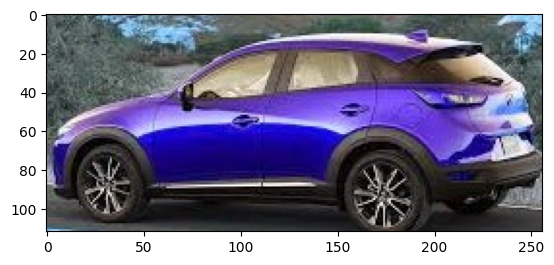

In [8]:
for category in CATEGORIES:
    Path = os.path.join(Directory,category)
    for img in os.listdir(Path):
        img_array = cv2.imread(os.path.join(Path,img))
        plt.imshow(img_array)
        plt.show()
        break
    break

In [9]:
no_of_images = {}
for dir in os.listdir(Directory):
    no_of_images[dir] = len(os.listdir(os.path.join(Directory,dir)))

no_of_images.items()

dict_items([('mazda', 2058), ('mitsubishi', 615), ('nissan', 3256), ('hyundai', 3839), ('ford', 2858), ('audi', 2156), ('mercedes', 1707), ('honda', 1318), ('toyota', 5667), ('bmw', 2104)])

In [10]:
# Splitting data 70% for Training, 15% for validation and 15% for Testing

def folderWiseSplitting(p, split):
    # Create the target folder if it doesn't exist
    target_folder = f"./{p}"
    if not os.path.exists(target_folder):
        os.mkdir(target_folder)

        # Iterate through categories
        for category in CATEGORIES:
            os.makedirs(os.path.join(target_folder, category))

            # Get a list of image filenames for the current category
            category_path = os.path.join(Directory, category)
            image_filenames = os.listdir(category_path)

            # Randomly select images for copying to the target folder
            selected_images = np.random.choice(image_filenames, size=(math.floor(split * len(image_filenames)) - 5), replace=False)

            # Copy selected images to the target folder
            for img in selected_images:
                source_path = os.path.join(category_path, img)
                destination_path = os.path.join(target_folder, category, img)
                shutil.copy(source_path, destination_path)

    else:
        print(f"{p}The folder exists.")

In [12]:
folderWiseSplitting("Train_1",0.7)

Train_1The folder exists.


In [13]:
# to count the number of images
import os

# Define the directory where the dataset is stored
train_directory = "/content/drive/MyDrive/Train_1"

# Initialize a dictionary to store the number of images per category
num_images_train = {}

# Iterate through categories
for category in CATEGORIES:
    # Get the path to the category folder in the training dataset
    category_path = os.path.join(train_directory, category)
    # Count the number of images in the category folder
    num_images = len(os.listdir(category_path))
    # Store the number of images for the current category
    num_images_train[category] = num_images

# Print the number of images in the training dataset per category
print("Number of images in train dataset per category:")
print(num_images_train)

Number of images in train dataset per category:
{'mazda': 1435, 'mitsubishi': 425, 'nissan': 2274, 'hyundai': 2682, 'ford': 1995, 'audi': 1504, 'mercedes': 1189, 'honda': 917, 'toyota': 3961, 'bmw': 1477}


In [15]:
folderWiseSplitting("Validation_1",0.15)

Validation_1The folder exists.


In [17]:
# to count the number of images
import os

# Define the directory where the dataset is stored
validation_directory = "/content/drive/MyDrive/Validation_1"

# Initialize a dictionary to store the number of images per category
num_images_validate = {}

# Iterate through categories
for category in CATEGORIES:
    # Get the path to the category folder in the validation dataset
    category_path = os.path.join(validation_directory, category)
    # Count the number of images in the category folder
    num_images = len(os.listdir(category_path))
    # Store the number of images for the current category
    num_images_validate[category] = num_images

# Print the number of images in the validation dataset per category
print("Number of images in validation dataset per category:")
print(num_images_validate)

Number of images in validation dataset per category:
{'mazda': 303, 'mitsubishi': 87, 'nissan': 483, 'hyundai': 570, 'ford': 423, 'audi': 318, 'mercedes': 251, 'honda': 192, 'toyota': 845, 'bmw': 310}


In [19]:
folderWiseSplitting("Test_1",0.15)

Test_1The folder exists.


In [20]:
# to count the number of images
import os

# Define the directory where the dataset is stored
Testing_directory = "/content/drive/MyDrive/Test_1"

# Initialize a dictionary to store the number of images per category
num_images_test = {}

# Iterate through categories
for category in CATEGORIES:
    # Get the path to the category folder in the Testing dataset
    category_path = os.path.join(Testing_directory, category)
    # Count the number of images in the category folder
    num_images = len(os.listdir(category_path))
    # Store the number of images for the current category
    num_images_test[category] = num_images

# Print the number of images in the testing dataset per category
print("Number of images in testing dataset per category:")
print(num_images_test)

Number of images in testing dataset per category:
{'mazda': 303, 'mitsubishi': 87, 'nissan': 483, 'hyundai': 570, 'ford': 423, 'audi': 318, 'mercedes': 251, 'honda': 192, 'toyota': 845, 'bmw': 310}


# Data Preprocessing of Images

In [21]:
def preprocessingImages_Train(path):
    image_data = ImageDataGenerator(zoom_range=0.2,shear_range=0.2, rescale=1/255, horizontal_flip=True)
    image = image_data.flow_from_directory(directory=path,target_size= (400,400),batch_size=32,class_mode="categorical")
    return image

In [22]:
path = "/content/drive/MyDrive/Train_1"
trainingdata = preprocessingImages_Train(path)

Found 17858 images belonging to 10 classes.


In [23]:
def preprocessingImages_Test(path):
    image_data = ImageDataGenerator(rescale=1/255)
    image = image_data.flow_from_directory(directory=path,target_size= (400,400),batch_size=32,class_mode="categorical")
    return image

In [25]:
path = "/content/drive/MyDrive/Test_1"
testingdata = preprocessingImages_Test(path)

Found 3782 images belonging to 10 classes.


In [24]:
def preprocessingImages_Validate(path):
    image_data = ImageDataGenerator(rescale=1/255)
    image = image_data.flow_from_directory(directory=path,target_size= (400,400),batch_size=32,class_mode="categorical")
    return image

In [26]:
path = "/content/drive/MyDrive/Validation_1"
validatingdata = preprocessingImages_Validate(path)

Found 3781 images belonging to 10 classes.


# ***CNN Model Building***

In [27]:
cnn = tf.keras.models.Sequential()

# ***Building Convolution Layer***

In [28]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(400,400, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1500, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Model Compilation

In [29]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 400, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 398, 398, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 199, 199, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 197, 197, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                 

# Keras callbacks: EarlyStopping and ModelCheckpoint.

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta= 0.01, patience= 6, verbose= 1, mode = "auto")

# model check point
mc = ModelCheckpoint(monitor="accuracy", filepath="./bestmodel.keras", verbose= 1 , save_best_only= True , mode = "auto")

cd = [es,mc]


# Model Training


hs = model.fit(trainingdata,
               epochs=25,
               verbose=1,
               validation_data=validatingdata,
               validation_steps=1,
               validation_split=0.1,


- `trainingdata`: This should be your training dataset, likely in the form of a generator or a NumPy array containing the training samples and labels.

- `epochs=25`: This specifies the number of times the model will iterate over the entire training dataset. In this case, the model will go through the training dataset 25 times.

- `verbose=1`: It controls the verbosity during training. Setting it to 1 means that progress bars will be displayed during training.

- `validation_data=validatingdata`: This should be your validation dataset, similar to the training dataset, used to monitor the model's performance on unseen data during training.

- `validation_steps=1`: This parameter is the number of steps to run validation for in each epoch. It's usually set to the number of batches in your validation dataset.

- `validation_split=0.1`: If you haven't provided a separate validation dataset (`validatingdata`), this parameter specifies the fraction of the training data to be used as validation data. In this case, 10% of the training data is used for validation.

- `callbacks=cd`: This parameter takes a list of callbacks. In your case, you have `EarlyStopping` and `ModelCheckpoint` callbacks (`cd`), which will control early stopping based on validation accuracy and save the best model during training.

After training, the history (`hs`) object will contain information about the training and validation metrics at each epoch. You can use this information to visualize the training process and evaluate the model's performance.


In [32]:
# Define batch size
batch_size = 64  # Adjust this value based on your data generator configuration

# Model Training
# Adjust steps_per_epoch based on the size of your dataset and batch size
steps_per_epoch = len(trainingdata) // batch_size
validation_steps = len(validatingdata) // batch_size

# Train the model
history = cnn.fit(
    trainingdata,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    validation_data=validatingdata,
    validation_steps=validation_steps,
    callbacks=cd
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 2.2285 - accuracy: 0.1992
Epoch 1: accuracy improved from -inf to 0.19922, saving model to ./bestmodel.keras
8/8 [==============================] - 127s 12s/step - loss: 2.2285 - accuracy: 0.1992 - val_loss: 2.0630 - val_accuracy: 0.3125
Epoch 2/25
8/8 [==============================] - ETA: 0s - loss: 2.1890 - accuracy: 0.2227 
Epoch 2: accuracy improved from 0.19922 to 0.22266, saving model to ./bestmodel.keras
8/8 [==============================] - 102s 13s/step - loss: 2.1890 - accuracy: 0.2227 - val_loss: 2.0419 - val_accuracy: 0.3438
Epoch 3/25
8/8 [==============================] - ETA: 0s - loss: 2.2099 - accuracy: 0.2578
Epoch 3: accuracy improved from 0.22266 to 0.25781, saving model to ./bestmodel.keras
8/8 [==============================] - 95s 12s/step - loss: 2.2099 - accuracy: 0.2578 - val_loss: 2.3003 - val_accuracy: 0.1562
Epoch 4/25
8/8 [==============================] - ETA: 0s - loss: 2.2023 - accuracy: 0.1875
E

##  The history object (hs) contains information about the training process, including various metrics recorded at each epoch. The keys in h typically include;
## This will give you a list of available metrics. Common keys include:

#### **1) 'loss':** *Training loss at each epoch.*
#### **2) 'accuracy':** *Training accuracy at each epoch.*
#### **3) 'val_loss':** *Validation loss at each epoch (if you have a validation set).*
#### **4) 'val_accuracy':** *Validation accuracy at each epoch (if you have a validation set).*

In [33]:
h= history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
training_loss = h['loss']
training_accuracy = h['accuracy']
validation_loss = h['val_loss']
validation_accuracy = h['val_accuracy']

# Data & Trained Model Visualization

# Matplotlib Line plot graph Visualization of the training accuracy (accuracy) and validation accuracy (val_accuracy)

#### Using matplotlib to create a line plot of the training accuracy (accuracy) and validation accuracy (val_accuracy) over epochs to visualize the learning progress of our model during training.

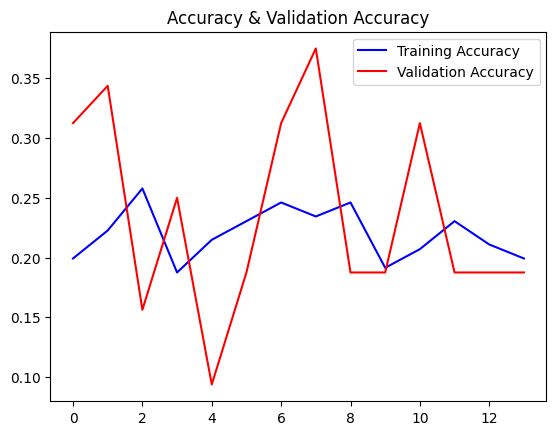

In [35]:
import matplotlib.pyplot as plt

# Plotting training accuracy in blue
plt.plot(h["accuracy"], c="blue", label='Training Accuracy')

# Plotting validation accuracy in red
plt.plot(h["val_accuracy"], c="red", label='Validation Accuracy')

# Adding a title to the plot
plt.title("Accuracy & Validation Accuracy")

# Adding a legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()


### In this plot:
- The x-axis typically represents the number of epochs.
- The y-axis represents the accuracy.
- The blue line (`Training Accuracy`) shows the training accuracy at each epoch.
- The red line (`Validation Accuracy`) shows the validation accuracy at each epoch.

## Things to strickly Note:
### This plot can help you assess how well your model is learning from the training data and how well it generalizes to unseen data (validation set). If the training accuracy is significantly higher than the validation accuracy, it might indicate overfitting. If both are low, it might indicate underfitting. If both are high, your model is likely performing well.


# Matplotlib Line plot graph Visualization of the training loss (loss) and validation loss (val_loss)

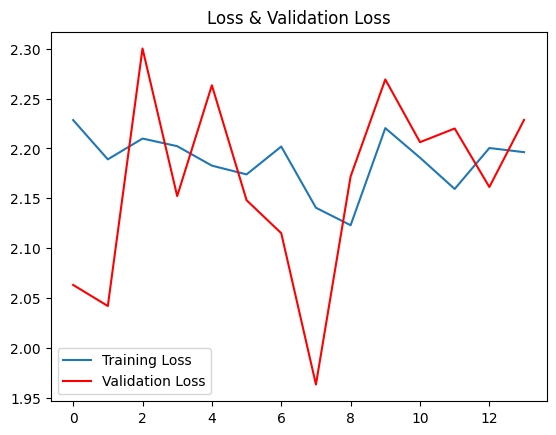

In [36]:
import matplotlib.pyplot as plt

# Plotting training loss in blue
plt.plot(h["loss"], label='Training Loss')

# Plotting validation loss in red
plt.plot(h["val_loss"], c="red", label='Validation Loss')

# Adding a title to the plot
plt.title("Loss & Validation Loss")

# Adding a legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()


#### The code is plotting the training loss (`loss`) and validation loss (`val_loss`) over epochs to visualize to assess the performance and convergence of your model during training.

### In this plot:
- The x-axis typically represents the number of epochs.
- The y-axis represents the loss value.
- The blue line (`Training Loss`) shows the training loss at each epoch.
- The red line (`Validation Loss`) shows the validation loss at each epoch.

## Things to strickly Note:
## This plot helps you monitor how well your model is minimizing the loss function on both the training and validation sets. You want both the training and validation loss to decrease over epochs. If the training loss is decreasing but the validation loss starts to increase, it could indicate overfitting.

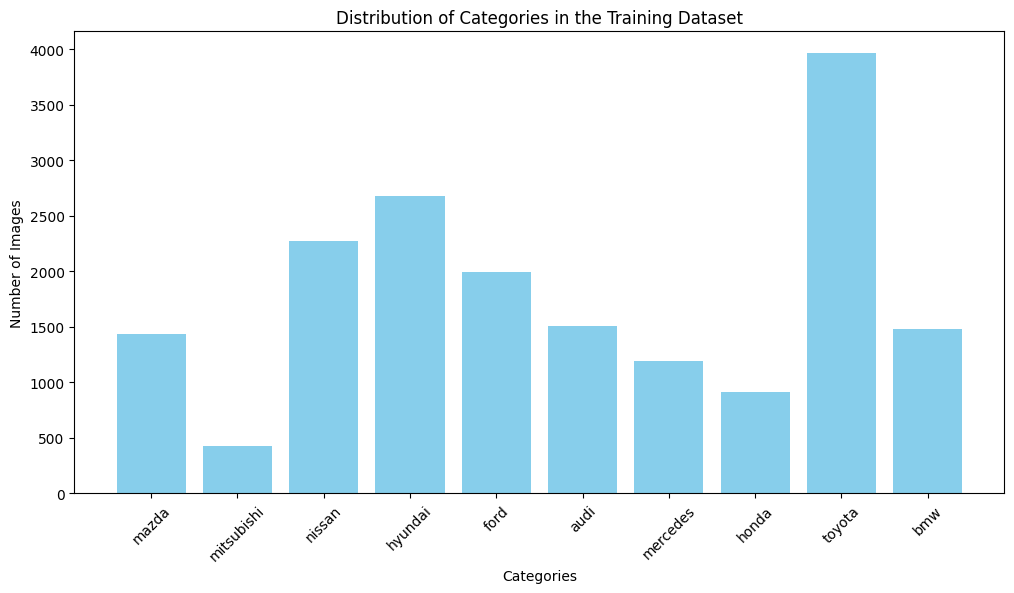

In [37]:
# Assuming num_images_train is a dictionary with category counts
categories = list(num_images_train.keys())
values = list(num_images_train.values())

plt.figure(figsize=(12, 6))
plt.bar(categories, values, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Categories in the Training Dataset')
plt.xticks(rotation=45)
plt.show()

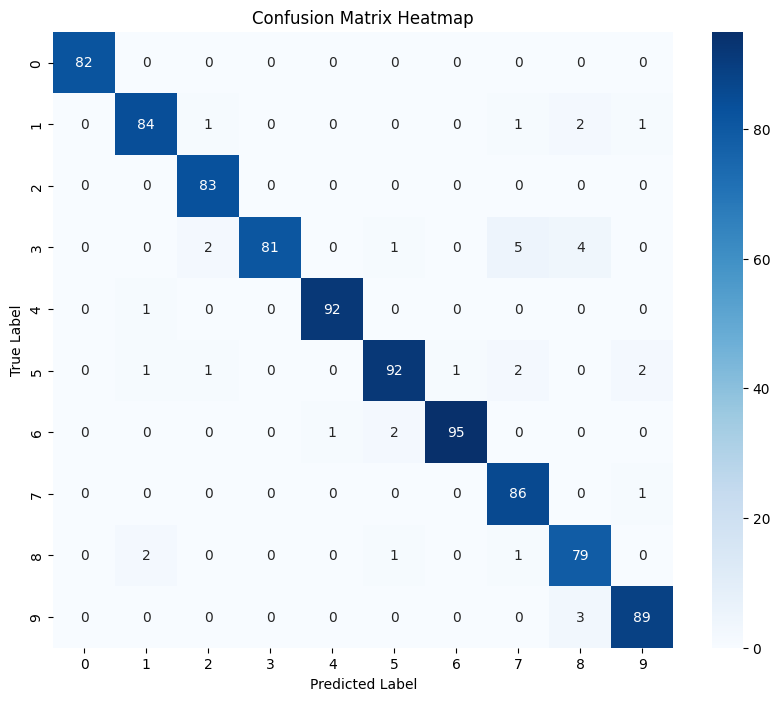

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load example dataset
digits = load_digits()
X, y = digits.data, digits.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train a classifier
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Checking the Model Accuracy

In [41]:
from keras.models import load_model

# Load the saved model
model = load_model("/content/bestmodel.keras")

# Evaluate the model on the testing data
loss, acc = model.evaluate(testingdata)
print(f"The accuracy of our model is {acc * 100} %")


119/119 [==============================] - 783s 7s/step - loss: 2.1741 - accuracy: 0.2234
The accuracy of our model is 22.342675924301147 %


# Now Loading an image using TensorFlow's image preprocessing utilities and making a prediction using our trained model.

# **Load Model**

In [42]:
from keras.models import load_model

# Load the saved model
model = load_model("/content/bestmodel.keras")

# Print the summary of the loaded model
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 400, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 398, 398, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 199, 199, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 197, 197, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                 

In [43]:
#Test Image Visualization
import cv2
image_path = "/content/Test_1/honda/honda-accord-generation-2008-2012-100.jpg"

# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


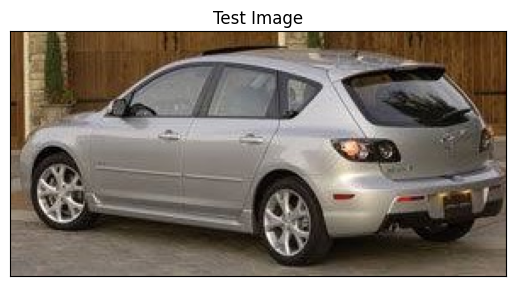

In [45]:
# Check if the image path is correct and that the image file exists
import os

image_path = "/content/Test_1/mazda/mazda-3-gen-2009-2013-153.jpg"

if not os.path.exists(image_path):
    raise ValueError(f"Image file not found at {image_path}")

# Load the image using OpenCV
import cv2

img = cv2.imread(image_path)

# Check if the image loaded successfully
if img is None:
    raise ValueError(f"Failed to load image at {image_path}")

# Convert the image from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [46]:
img.shape

(144, 292, 3)

In [47]:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(400,400))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

1/1 [==============================] - 1s 666ms/step


In [48]:
print(predictions)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [49]:
# Get the predicted class label
predicted_class_index = np.argmax(predictions)
print(predicted_class_index)

9


In [50]:
# Assuming you have the predicted_class_index variable containing the index of the predicted class

# Define the class_indices dictionary
class_indices = {'Audi': 1,
                 'BMW': 2,
                 'Ford': 3,
                 'Hyundai': 4,
                 'Mazda': 5,
                 'Mercedes': 6, 'Mitsubishi': 7,
                 'Nissan': 8,
                 'Honda': 9,
                 'Toyota': 10}

# Reverse the class_indices dictionary
class_labels = {v: k for k, v in class_indices.items()}

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]  # Get the label corresponding to the predicted index

print("Predicted Class Label:", predicted_class_label)


Predicted Class Label: Honda


In [51]:
# Make predictions using the trained model on your testing data
predictions = []
for i in range(len(testingdata)):
    images, labels = next(testingdata)
    preds = model.predict(images)
    for j, pred in enumerate(preds):
        predicted_class_index = np.argmax(pred)
        predicted_class = list(testingdata.class_indices.keys())[predicted_class_index]
        score = pred[predicted_class_index]
        image_filename = f'image_{i * testingdata.batch_size + j}.jpg'
        predictions.append({'image': image_filename, 'predicted_class': predicted_class, 'score': score})

# Print predictions in the specified format
for prediction in predictions:
    print(f"Image: {prediction['image']}, Predicted Class: {prediction['predicted_class']}, Score: {prediction['score']:.4f}")

1/1 [==============================] - 0s 45ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 27ms/step
Image: image_0.jpg, Predicted Class: toyota, Score: 0.1896
Image: image_1.jpg, Predicted Class: toyota, Score: 0.2193
Image: image_2.jpg, Predicted Class: toyota, Score: 0.1701
Image: image_3.jpg, Predicted Class: toyota, Score: 0.1901
Image: image_4.jpg, Predicted Class: toyota, Score: 0.1599
Image: image_5.jpg, Predicted Class: toyota, Score: 0.1985
Image: image_6.jpg, Predicted Class: toyota, Score: 0.1863
Image: image_7.jpg, Predicted Class: toyota, Score: 0.1940
Image: image_8.jpg, Predicted Class: toyota, Score: 0.2075
Image: image_9.jpg, Predicted Class: toyota, Score: 0.1634
Image: image_10.jpg, Predicted Class: toyota, Score: 0.2016
Image: image_11.jpg, Predicted Class: toyota, Score: 0.1834
Image: image_12.jpg, Predicted Class: toyota, Score: 0.1973
Image: image_13.jpg, Predicted Class: toyota, Score: 0.1763
Image: image_14.jpg, Predicted Class: toyota, Score: 0.2135
Image: image_15.jpg, Predicted Class: toyota, Score: 0.203

In [52]:

# Stop the Spark session
spark.stop()